In [1]:
import scipy
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift, estimate_bandwidth

import pandas as pd

from scipy import stats
from scipy.stats import beta
from math import sin
from random import randint

import matplotlib.pyplot as plt
import itertools as it

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
init_notebook_mode(connected=True)

import collections

def recursively_default_dict():
        return collections.defaultdict(recursively_default_dict)

from matplotlib.collections import BrokenBarHCollection
import re

from structure_tools.Modules_tools import return_fsts


In [2]:
vcf_file= 'data.vcf'

Input= open(vcf_file)

info_summ= {}
info_save= list(range(5))

phased= False
header_len= 9
summary= []

Miss= recursively_default_dict()

genotype= []
d= 0

for line in Input:    
    line= line.strip()
    
    if d in info_save:
        
        line= ''.join(filter(lambda ch: ch not in "#", line))
        line= line.split('=')
        info_summ[line[0]] = ''.join(line[1:])
        d += 1
        continue
        
    
    if d == (len(info_save)):
        line= ''.join(filter(lambda ch: ch not in "#", line))
        line= line.split()
        
        columns= line[:header_len]
        
        Fam= {
            line[x]: x for x in range(header_len,len(line))
        }
        
        d += 1
        continue
        
    if d > (len(info_save)):
        line= line.split()
        seq= []

        info= line[:header_len]
        chrom= re.search(r'\d+', line[0]).group()
        info[0]= chrom

        summary.append(info)

        for ind in range(header_len,len(line)):
            locus= line[ind]
            alleles= locus.split(':')[0]
            alleles= list(map(int, re.findall(r'\d+', alleles)))
            if phased:
                seq.extend(alleles)
            else:
                seq.append(sum(alleles))

        genotype.append(seq)
        d += 1

Input.close()

summary= np.array(summary)
summary= pd.DataFrame(summary,columns= columns)
genotype= np.array(genotype).T

genotype.shape

(200, 19112)

In [201]:

print('Number of markers: {}'.format(genotype.shape[1]))

print('Number of individuals: {}'.format(genotype.shape[0]))

pca2 = PCA(n_components=3, whiten=False,svd_solver='randomized')

feats= pca2.fit_transform(genotype)

##

## perform MeanShift clustering.
bandwidth = estimate_bandwidth(feats, quantile=0.15)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=False, cluster_all=True, min_bin_freq=15)
ms.fit(feats)
labels1 = ms.labels_
label_select = {y:[x for x in range(len(labels1)) if labels1[x] == y] for y in sorted(list(set(labels1)))}

##

PCA_color_ref= ['darkseagreen','crimson', 'cyan', 'darkblue', 'darkcyan',
            'darkgoldenrod', 'darkgray', 'darkgrey', 'darkgreen',
            'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange',
            'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
            'darkslateblue', 'darkslategray', 'darkslategrey',
            'darkturquoise', 'darkviolet', 'deeppink']

from plotly import tools

fig_pca_subplots = tools.make_subplots(rows=1, cols=2,subplot_titles=tuple(['global','global']))

for subp in range(2):
    
    n_plot= subp
    
    coords= label_select
    
    for i in coords.keys():
        trace= go.Scatter(
        x = feats[coords[i],0],
        y = feats[coords[i],subp + 1],
        mode= "markers",
        name= str(i),
        marker= {
        'color': PCA_color_ref[i],
        'line': {'width': 0},
        'size': 6,
        'symbol': 'circle',
        "opacity": .8})
        
        fig_pca_subplots.append_trace(trace, int(n_plot/float(2)) + 1, subp + 1)
    
    fig_pca_subplots['layout']['yaxis' + str(n_plot + 1)].update(title='PC{}'.format(subp + 2))
    fig_pca_subplots['layout']['xaxis' + str(n_plot + 1)].update(title='PC1')

layout = go.Layout()

fig= go.Figure(data=fig_pca_subplots, layout=layout)
iplot(fig)

Number of markers: 19112
Number of individuals: 200
This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [202]:
##### 
Steps= 20
window_size= 150

window_starts= list(np.arange(0,genotype.shape[1],Steps))
if window_starts[-1] != genotype.shape[1]:
    window_starts.append(genotype.shape[1])

Windows= recursively_default_dict()
Out= recursively_default_dict()

lengths_winds= []

for splyt in range(len(window_starts) - 1):
    IN= window_starts[splyt]
    OUT= window_starts[splyt] + window_size
    
    if OUT > genotype.shape[1]:
        OUT= genotype.shape[1] - 1
    range_window= [IN,OUT]
    
    lengths_winds.append(OUT-IN)
    
    chrom= int(summary.CHROM[range_window[0]])
    
    start= int(summary.POS[range_window[0]])
    end= int(summary.POS[range_window[1]])
    
    Windows[chrom][start]= genotype[:,range_window[0]:range_window[1]]
    Out[chrom][start]= end
    
    if OUT-IN < window_size:
        break



In [206]:
## a look at local windows

windows_pick= 4
Chr= 1
Ncols= 2
height= 1500
width= 1000

windows_pick= np.random.choice(list(Windows[1].keys()),windows_pick,replace= False)
titles= ['window: ' + str(x) for x in windows_pick]
titles= np.repeat(titles,2)

fig_pca_subplots = tools.make_subplots(rows= int(len(titles) / float(Ncols)) + (len(titles) % Ncols > 0), cols=Ncols,
                         subplot_titles=tuple(titles))

n_plot= 1
for row in range(len(windows_pick)):
    pca_local= PCA(n_components=3, whiten=False,svd_solver='randomized')

    feats_local= pca_local.fit_transform(Windows[1][windows_pick[row]])
    
    for subp in range(2):

        coords= label_select

        for i in coords.keys():
            trace= go.Scatter(
            x = feats_local[coords[i],0],
            y = feats_local[coords[i],subp + 1],
            mode= "markers",
            name= str(i),
            marker= {
            'color': PCA_color_ref[i],
            'line': {'width': 0},
            'size': 6,
            'symbol': 'circle',
            "opacity": .8})
            
            fig_pca_subplots.append_trace(trace, row + 1, subp + 1)
        
        fig_pca_subplots['layout']['yaxis' + str(n_plot)].update(title='PC{}'.format(subp + 2))
        fig_pca_subplots['layout']['xaxis' + str(n_plot)].update(title='PC1')
        n_plot += 1

fig_pca_subplots['layout'].update(height= height,width= width)

iplot(fig_pca_subplots)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]
[ (4,1) x7,y7 ]  [ (4,2) x8,y8 ]



In [143]:
### KDE analysis across windows
from structure_tools.Sim_ideogram_tools import Merge_class, extract_profiles, KDE_windows, return_ideogram

## Use result of MS classification.
ref_labels= [1,2,3]
kde_class_labels= labels1

Comparison_threshold= 1
Outlier_threshold= 1e-5
n_comps= 4

color_ref= ['red','yellow','blue','black','orange','purple','green','silver','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

ideo_kde,chromosome_list, ID, var_comp_store= KDE_windows(Windows,kde_class_labels,ref_labels,Out,colors= 'alt',n_comps=n_comps,alt_col= color_ref,Comparison_threshold= Comparison_threshold,Outlier_threshold= Outlier_threshold)


adding ideograms...


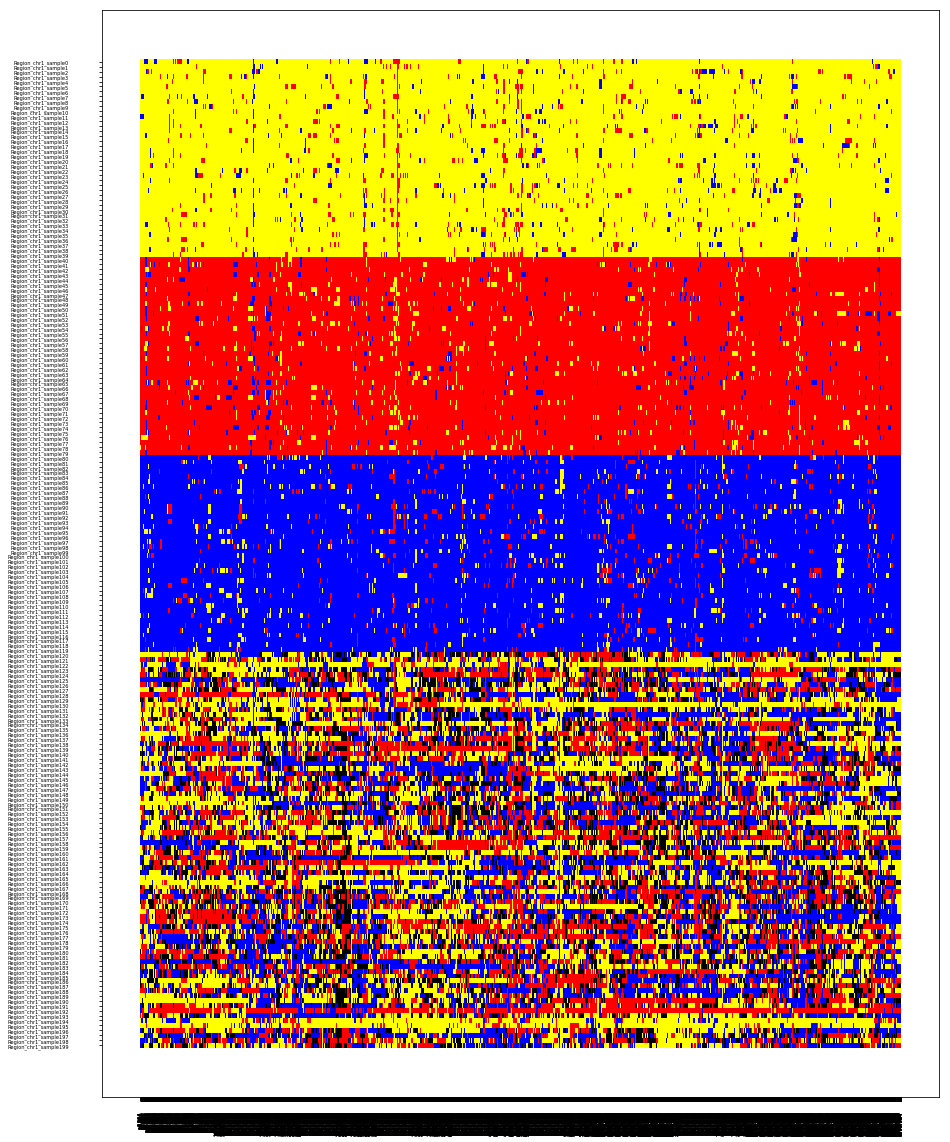

In [144]:
Fig_ideo= return_ideogram(ideo_kde,chromosome_list,ID,height= 20,width= 15)